# C01: Towards More Rigorous Validation

---

The following is a "chapter sketch"---a rough proof-of-concept of an example chapter.

Below I introduce a trajectory fitting problem. The data are generated under a quadratic draw law, but fitting is performed under a linear drag law.

Learning goals:

- Learn to recognize and diagnose **model-form error**
- Use independent **validation data** to assess a fitted model

### Code setup

In [1]:
## Import packages
import grama as gr
import numpy as np
import pandas as pd
from plotnine import *
from scipy.optimize import minimize

DF = gr.Intention()

## Import case study
# -------
# Path hack
import sys, os
sys.path.insert(0, os.path.abspath('..'))
# Import fitting tools
from scripts import c01_param_error, c01_compute_traj, c01_linear_traj, c01_true_rhs
from scripts import c01_compute_error, c01_compute_resid, c01_param_cov, c01_linear_ci
# Import data
df_full = (
    pd.read_csv("../data/c01_meas_full.csv")
    >> gr.tf_mutate(source="Full")
)
df_windowed = (
    pd.read_csv("../data/c01_meas_windowed.csv")
    >> gr.tf_mutate(source="Windowed")
)
df_range = pd.read_csv("../data/c01_range_traj.csv")


## Data Inspection

---


### Visualized Trajectory


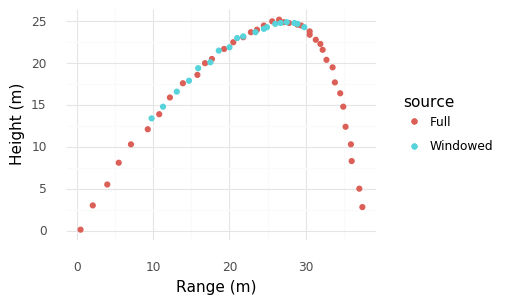

<ggplot: (281410293)>

In [2]:
(
    ggplot()
    + geom_point(df_full, aes("x", "y", color="source"))
    + geom_point(df_windowed, aes("x", "y", color="source"))
    + theme_minimal()
    + theme(figure_size=(4, 3))
    + labs(x="Range (m)", y="Height (m)")
)

We have two sources of data:

The **windowed** data give us slice of time in the middle of the trajectory.

The **full** data give us the entire trajectory, from the starting location to the end.

It is common in practice to have data more similar to the windowed case: Limitations in measurement will often prevent us from measuring everywhere we might like.


**Objective**:

- Predict the range of the projectile based on the given data

**Approach**:

- Develop a physics-based model
- Calibrate the model based on given data
- Use the model to predict the projectile range


## Modeling

---



### Model Definition

A projectile of fixed mass subject to gravity and drag. Model for velocity $u=dx/dt, v=dy/dt$ given by

$$m \frac{du}{dt} = F_x(u, v)$$
$$m \frac{dv}{dt} = F_y(u, v) - m g$$

With a linear drag law

$$F_x(u, v) = - b u$$
$$F_y(u, v) = - b v$$

### Refactored model

Analytic solution

$$x = \tau u_0 (1 - \exp(-t/\tau)) + x_0$$
$$y = \tau (v_0 - v_{\infty})(1 - \exp(-t/\tau)) + v_{\infty} t + y_0$$

where $\tau = m/b$ is the characteristic time, and $v_{\infty} = g \tau$ is the terminal velocity.

Unknowns:

| Sym. | Quantity |
|---|---|
| $u_0$ | Initial velocity; horizontal |
| $v_0$ | Initial velocity; vertical |
| $\tau$ | Characteristic time |


### Model Fitting

---

A *residual* is a discrepancy between the observed and modeled values, that is

$$r_i = f_{\text{sim},i}(\theta) - f_{\text{meas},i}.$$

**Concept**: Least Squares Optimization; minimization $\min_{\theta} MSE^2$, where

$$MSE^2 = \sum_{i=1}^{N_{\text{data}}} (f_{\text{sim},i}(\theta) - f_{\text{meas},i})^2$$

**Procedure**:

1. Select initial guess $\theta_j = [u_0, v_0, b, m]$ for $j=0$
1. Simulate trajectory $x(t, \theta_j), y(t, \theta_j)$ 
1. Compute squared error $E^2(\theta_j)$
1. Select next $\theta_{j+1}$ by seeking minimum of $E^2$
1. Repeat from (2) until $E^2$ is sufficiently converged

We will use the `scipy.optimize.minimize` routine to carry out optimization of $E^2$ over $\theta$.

In [3]:
def compute_error(theta, df_ref):
    # Simulate trajectory
    df_sim = c01_linear_traj(theta, T_integrate=df_ref.t)
    # Compute residuals
    x_resid = df_sim.x - df_ref.x
    y_resid = df_sim.y - df_ref.y
    # Return L2 error
    return np.sum(np.sum(x_resid**2) + np.sum(y_resid**2))


The function `c01_linear_traj` is an external that solves the governing equations and returns a trajectory *conditional* on the provided parameter values `theta`. Learning how to write a function like `c01_linear_traj` is *extensively* covered by other domain-specific texbooks and courses. Here we focus on *how to use* such a simulation, along with data, to handle uncertainty.

## Windowed trajectory

Next, we optimize over `compute_error` to find fitted parameter values. We do so first only using the windowed data.


Optimization Success: True ; Optimization terminated successfully.
[18.79216821 28.23480007  2.80224914]


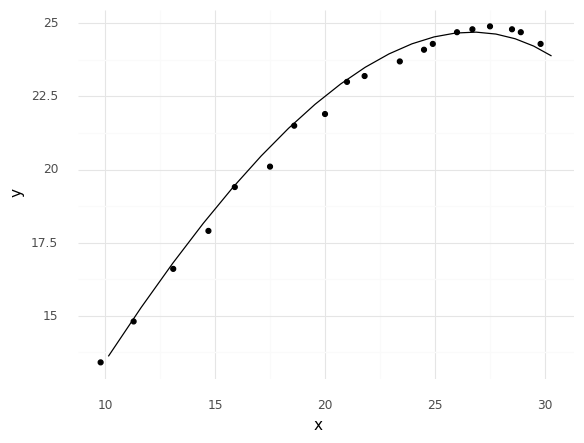

<ggplot: (7552876333)>

In [4]:
## Minimize error
theta0 = np.array([10, 20, 1])
res = minimize(
    lambda theta: compute_error(theta, df_windowed),
    theta0,
    method="Nelder-Mead",
    options={"maxfev": 1000}
)
theta_w = res.x

print("Optimization Success:", res.success, ";", res.message)
print(theta_w)

df_windowed_fit = c01_linear_traj(theta_w, T_integrate=df_windowed.t)

(
    ggplot(mapping=aes("x", "y"))
    + geom_line(data=df_windowed_fit)
    + geom_point(data=df_windowed)
    + theme_minimal()
)

**Observations**:

(Eyeball norm is good)

### Quantify the uncertainty

In a future chapter, we will introduce various ways to represent and quantify uncertainty. For now, we will report *confidence intervals* on the projectile $x(t_i), y(t_i)$ pairs. These intervals are constructed to include the true trajectory with high confidence.


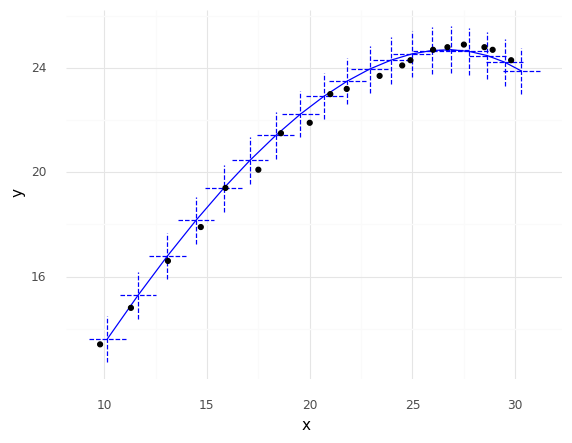

<ggplot: (7552315429)>

In [5]:
## Assess uncertainty
cov_w, var_w = c01_param_cov(df_windowed_fit, theta_w)
df_ci = c01_linear_ci(theta_w, cov_w, var_w, df_windowed_fit.t)

## Visualize
(
    ggplot(
        data=df_windowed_fit
        >> gr.tf_bind_cols(df_ci)
    )
    + geom_line(
        mapping=aes("x", "y"),
        color="blue",
    )
    + geom_segment(
        mapping=aes("x_lo", "y", xend="x_hi", yend="y"),
        color="blue",
        linetype="dashed",
    )
    + geom_segment(
        mapping=aes("x", "y_lo", xend="x", yend="y_hi"),
        color="blue",
        linetype="dashed",
    )
    + geom_point(
        data=df_windowed,
        mapping=aes("x", "y")
    )
    + theme_minimal()
)

**Observations**:

- The measured trajectory points fall within the confidence intervals. This seems to indicate that the model is compatible with the data.
- However, inspecting the residuals indicates an issue:


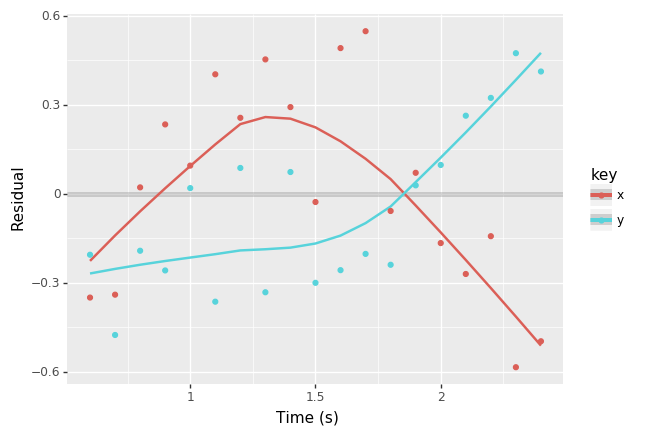

<ggplot: (7552897893)>

In [6]:
(
    ggplot(
        data=df_windowed_fit
        >> gr.tf_left_join(
            df_windowed
            >> gr.tf_rename(x_meas="x", y_meas="y"),
            by="t"
        )
        >> gr.tf_mutate(
            x_resid=DF.x_meas - DF.x,
            y_resid=DF.y_meas - DF.y,
        )
        >> gr.tf_select(["t", "x_resid", "y_resid"])
        >> gr.tf_gather("key", "value", ["x_resid", "y_resid"])
        >> gr.tf_mutate(key=gr.str_sub(DF.key, end=1))
    )
    
    + geom_hline(yintercept=0, color="grey", size=2, alpha=1/3)
    + geom_smooth(mapping=aes("t", "value", color="key"))
    + geom_point(mapping=aes("t", "value", color="key"))
    
    + labs(
        x="Time (s)",
        y="Residual",
    )
)

**Observations**:

If the noise were truly random, the residuals should have no discernible pattern in time. However, we can see a strong trend in the residuals, particularly as time advances. To see the issue more clearly, we check how the model fit performs on the full dataset:

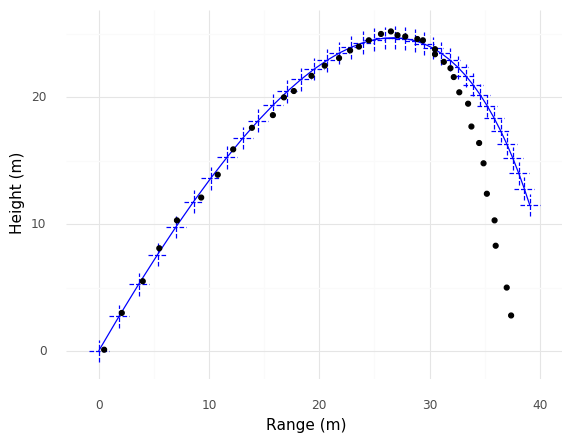

<ggplot: (7553464669)>

In [7]:
## Use windowed fit parameters to simulate full trajectory
df_test_fit = c01_linear_traj(theta_w, T_integrate=df_full.t)
df_ci = c01_linear_ci(theta_w, cov_w, var_w, df_test_fit.t)

## Visualize
(
    ggplot(
        data=df_test_fit
        >> gr.tf_bind_cols(df_ci)
    )
    + geom_line(
        mapping=aes("x", "y"),
        color="blue",
    )
    + geom_segment(
        mapping=aes("x_lo", "y", xend="x_hi", yend="y"),
        color="blue",
        linetype="dashed",
    )
    + geom_segment(
        mapping=aes("x", "y_lo", xend="x", yend="y_hi"),
        color="blue",
        linetype="dashed",
    )
    + geom_point(
        data=df_full,
        mapping=aes("x", "y")
    )
    + theme_minimal()
    + labs(
        x="Range (m)",
        y="Height (m)",
    )
)


**Observations**:

- The model we fit failed to extrapolate!
- The trajectory with quantified uncertainties is confidently wrong!
- Using **validation data**---data not used to fit the model
  - Helps to diagnose model lack-of-fit
  - Particularly helpful if data is extrapolatory in the way we plan to use it


### Concept: Study the Residuals


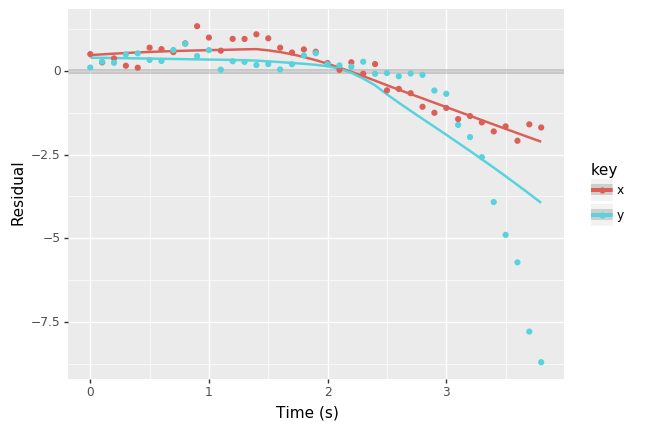

<ggplot: (7553025741)>

In [8]:
(
    ggplot(
        data=df_test_fit
        >> gr.tf_left_join(
            df_full
            >> gr.tf_rename(x_meas="x", y_meas="y"),
            by="t"
        )
        >> gr.tf_mutate(
            x_resid=DF.x_meas - DF.x,
            y_resid=DF.y_meas - DF.y,
        )
        >> gr.tf_select(["t", "x_resid", "y_resid"])
        >> gr.tf_gather("key", "value", ["x_resid", "y_resid"])
        >> gr.tf_mutate(key=gr.str_sub(DF.key, end=1))
    )
    
    + geom_hline(yintercept=0, color="grey", size=2, alpha=1/3)
    + geom_smooth(mapping=aes("t", "value", color="key"))
    + geom_point(mapping=aes("t", "value", color="key"))
    
    + labs(
        x="Time (s)",
        y="Residual",
    )
)

**Observations**:

- There is a clear pattern in the residuals. As time marches forward, the residuals tend to grow larger (in magnitude). This is not an uncommon occurrence in time-evolution problems.


## Re-fit on full trajectory

---

Is it possible for us to capture the correct behavior by fitting the model on the full data?


Optimization terminated successfully.
[20.98327212 29.43942911  2.1097761 ]


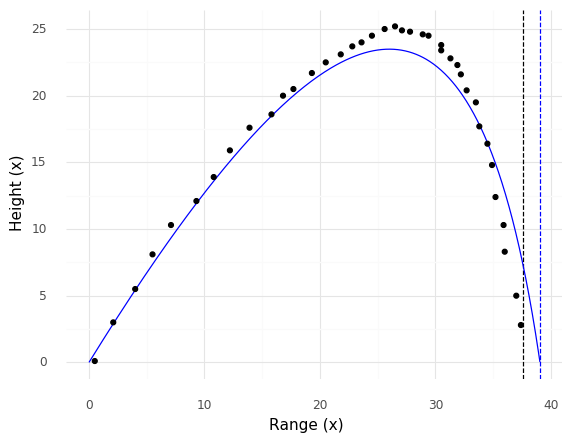

<ggplot: (7553713113)>

In [9]:
## Minimize error
theta0 = np.array([20, 30, 2])
res = minimize(
    lambda theta: compute_error(theta, df_full),
    theta0,
    method="Nelder-Mead",
    options={"maxfev": 1000}
)
rmse = res.fun
theta_f = res.x

print(res.message)
print(theta_f)

df_dense_fit = c01_linear_traj(theta_f, T_integrate=np.linspace(0, 5.0, num=500))

p = (
    ggplot(mapping=aes("x", "y"))
    + geom_vline(
        xintercept=np.max(df_range >> gr.tf_pull(DF.x)),
        linetype="dashed"
    )
    + geom_vline(
        xintercept=np.max(
            df_dense_fit 
            >> gr.tf_filter(DF.y >= 0)
            >> gr.tf_pull(DF.x)
        ),
        linetype="dashed",
        color="blue"
    )
    + geom_line(
        data=df_dense_fit
        >> gr.tf_filter(DF.y >= 0),
        color="blue",
    )
    + geom_point(
        data=df_full,
    )
    + theme_minimal()
    + labs(
        x="Range (x)",
        y="Height (x)",
    )
)
p.save("../images/c01_linear_fit.png")
p


**Observations**

- The eyeball norm is bad; the trajectory undershoots the true peak height, and overestimates the projectile range

Add confidence intervals to quantify uncertainty


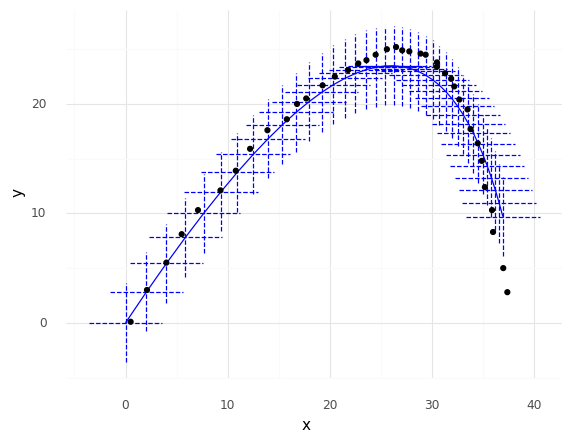

<ggplot: (7552315445)>

In [10]:
## Assess uncertainty
df_full_fit = c01_linear_traj(theta_f, T_integrate=df_full.t)
cov_f, var_f = c01_param_cov(df_full_fit, theta_f)
df_ci_f = c01_linear_ci(theta_f, cov_f, var_f, df_full_fit.t)

(
    ggplot(
        data=df_full_fit
        >> gr.tf_bind_cols(df_ci_f)
    )
    + geom_line(
        mapping=aes("x", "y"),
        color="blue",
    )
    + geom_segment(
        mapping=aes("x_lo", "y", xend="x_hi", yend="y"),
        color="blue",
        linetype="dashed",
    )
    + geom_segment(
        mapping=aes("x", "y_lo", xend="x", yend="y_hi"),
        color="blue",
        linetype="dashed",
    )
    + geom_point(
        data=df_full,
        mapping=aes("x", "y")
    )
    + theme_minimal()
)

**Observations**:

- The CI are now wider than the windowed fit
- The final points of the trajectory do not fall within confidence bounds; even the data used for fitting are not compatible with the model

Study the residuals


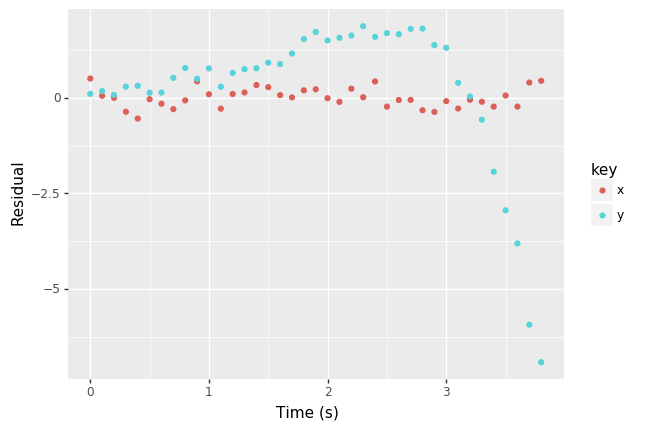

<ggplot: (7553604669)>

In [11]:
(
    ggplot(
        data=df_full_fit
        >> gr.tf_left_join(
            df_full
            >> gr.tf_rename(x_meas="x", y_meas="y"),
            by="t"
        )
        >> gr.tf_mutate(
            x_resid=DF.x_meas - DF.x,
            y_resid=DF.y_meas - DF.y,
        )
        >> gr.tf_select(["t", "x_resid", "y_resid"])
        >> gr.tf_gather("key", "value", ["x_resid", "y_resid"])
        >> gr.tf_mutate(key=gr.str_sub(DF.key, end=1))
    )
    + geom_point(mapping=aes("t", "value", color="key"))
    
    + labs(
        x="Time (s)",
        y="Residual",
    )
)

**Observations**:

- Despite training and testing on the same data, the model is still unable to capture the trend in the data. This is evidence that **the form of the model is in error**; there is model-form error.

### Issue: Model-form uncertainty


### Solution: Vigilance and skepticism

Unfortunately, **model-form** is simultaneously the most important source of uncertainty, and the most difficult form to treat.

## What's wrong with the model?

---

In truth, the data were generated not with a linear drag law, but rather with a *quadratic* drag law:

$$F_x(u, v) = - b u^2 / \sqrt{u^2+v^2}$$
$$F_y(u, v) = - b v^2 / \sqrt{u^2+v^2}$$

The following code re-fits the model and visualizes the new fitted trajectory.

Optimization terminated successfully.
[20.05254259 30.13735028  1.65495398]


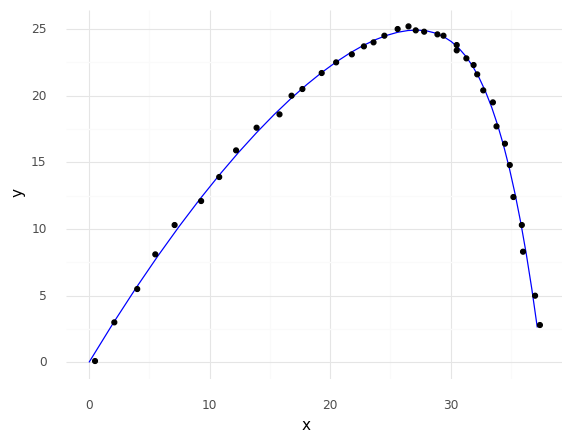

<ggplot: (7554081089)>

In [12]:
def compute_error_fixed(theta, df_ref):
    # Simulate trajectory
    df_sim = c01_compute_traj(theta, T_integrate=df_ref.t, rhs=c01_true_rhs)
    # Compute residuals
    x_resid = df_sim.x - df_ref.x
    y_resid = df_sim.y - df_ref.y
    # Return L2 error
    return np.sum(np.sum(x_resid**2) + np.sum(y_resid**2))

## Minimize error
theta0 = np.array([20, 30, 2])
res = minimize(
    lambda theta: compute_error_fixed(theta, df_full),
    theta0,
    method="Nelder-Mead",
    options={"maxfev": 1000}
)
rmse = res.fun
theta_f = res.x

print(res.message)
print(theta_f)

df_true_fit = c01_compute_traj(theta_f, T_integrate=df_full.t, rhs=c01_true_rhs)

(
    ggplot(mapping=aes("x", "y"))
    + geom_line(
        data=df_true_fit,
        color="blue",
    )
    + geom_point(
        data=df_full,
    )
    + theme_minimal()
)

**Observations**:

- The estimated parameter values are very close to the true values $u_0=20, v_0=30, \tau=1.66$ used to generate the data.
- The trajectory fit is nearly perfect.


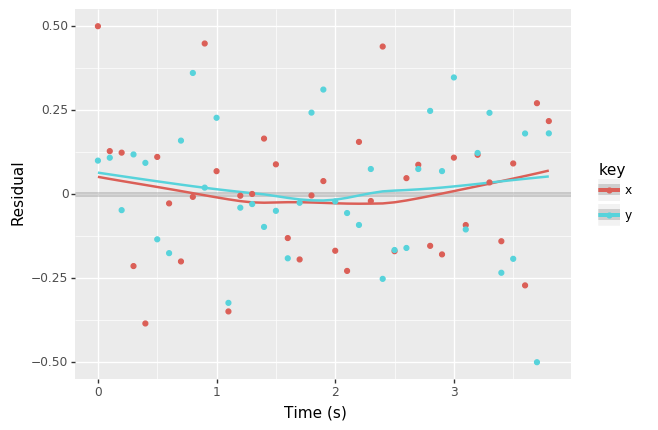

<ggplot: (7553684189)>

In [13]:
(
    ggplot(
        data=df_true_fit
        >> gr.tf_left_join(
            df_full
            >> gr.tf_rename(x_meas="x", y_meas="y"),
            by="t"
        )
        >> gr.tf_mutate(
            x_resid=DF.x_meas - DF.x,
            y_resid=DF.y_meas - DF.y,
        )
        >> gr.tf_select(["t", "x_resid", "y_resid"])
        >> gr.tf_gather("key", "value", ["x_resid", "y_resid"])
        >> gr.tf_mutate(key=gr.str_sub(DF.key, end=1))
    )
    
    + geom_hline(yintercept=0, color="grey", size=2, alpha=1/3)
    + geom_smooth(mapping=aes("t", "value", color="key"))
    + geom_point(mapping=aes("t", "value", color="key"))
    
    + labs(
        x="Time (s)",
        y="Residual",
    )
)

**Observations**:

- The residuals are largely without pattern in time. The edges of the smoothing curves bow up, but that is a common regression artifact.
